In [1]:
import os
import numpy as np
import tensorflow as tf
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

import cv2
from skimage import io



2024-09-26 07:05:29.825133: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-26 07:05:29.825225: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-26 07:05:29.953097: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
def error_level_analysis(image, quality_val=90):
    """
    Perform Error Level Analysis (ELA) on an image.
    
    Args:
        image (numpy.ndarray): Input image.
        quality_val (int): Quality value for JPEG compression (0-100).
        
    Returns:
        numpy.ndarray: Error Level Analysis image.
    """
    try:
        temp_filename = 'temp.jpg'
        _, encoded_img = cv2.imencode('.jpg', image, [cv2.IMWRITE_JPEG_QUALITY, quality_val])
        decoded_img = cv2.imdecode(encoded_img, cv2.IMREAD_UNCHANGED)

        ela_image = np.abs(image.astype(np.float32) - decoded_img.astype(np.float32))

        return ela_image
    except:
        return

In [3]:
real_path = '/kaggle/input/dalle-recognition-dataset/real'
fake_path = '/kaggle/input/dalle-recognition-dataset/fakeV2/fake-v2'

real_path2 = '/kaggle/input/ai-generated-images-vs-real-images/RealArt/RealArt'
fake_path2 = '/kaggle/input/ai-generated-images-vs-real-images/AiArtData/AiArtData'

In [4]:
real_images = [os.path.join(real_path,i) for i in os.listdir(real_path)]
real_images.extend([os.path.join(real_path2,i) for i in os.listdir(real_path2)])
fake_images = [os.path.join(fake_path,i) for i in os.listdir(fake_path)]
fake_images.extend([os.path.join(fake_path2,i) for i in os.listdir(fake_path2)])


In [5]:
def conv_to_arr(image_path):
    try:
        image = cv2.imread(image_path)

        # Resize the image to 224x224
        resized_image = cv2.resize(image, (224, 224))

        # Convert BGR to RGB
        resized_image_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)

        # Convert to numpy array
        image_array = np.array(resized_image_rgb)
        return image_array
        
    except:
        return


In [6]:
all_real_asarray = []
rcount = 0
for i in real_images:
    rcount +=1
    all_real_asarray.append(error_level_analysis(conv_to_arr(i)))
    if rcount%500==0:
        print(rcount)

all_fake_asarray = []
fcount = 0
for i in fake_images:
    fcount += 1
    all_fake_asarray.append(error_level_analysis(conv_to_arr(i)))
    if fcount > rcount:
        break
    if fcount%500==0:
        print(fcount)


libpng warning: iCCP: known incorrect sRGB profile


500


libpng warning: iCCP: known incorrect sRGB profile


1000


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


1500


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


2000


libpng warning: iCCP: known incorrect sRGB profile


2500
3000
3500


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'CMYK': invalid ICC profile color space


4000
500
1000
1500
2000
2500


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


3000


libpng warning: iCCP: known incorrect sRGB profile


3500
4000


In [7]:
del real_images
del fake_images

In [8]:
all_real_asarray_filtered = [i for i in all_real_asarray if i is not None and i.shape == (224, 224, 3)]
all_fake_asarray_filtered = [i for i in all_fake_asarray if i is not None and i.shape == (224, 224, 3)]

In [9]:
del all_real_asarray
del all_fake_asarray

In [10]:
X = np.concatenate((all_real_asarray_filtered, all_fake_asarray_filtered), axis=0)
# Create labels
y = np.zeros(len(all_real_asarray_filtered), dtype=np.uint8)  # Labels for real images
y = np.concatenate((y, np.ones(len(all_fake_asarray_filtered), dtype=np.uint8)))  # Labels for fake images

# Shuffle the data
indices = np.arange(len(X))
np.random.shuffle(indices)
X = X[indices]
y = y[indices]

np.save('X_imgdata',X)
np.save('y_imglabels',y)


In [11]:
X = np.load('X_imgdata.npy')
y = np.load('y_imglabels.npy')

In [12]:
print(X.shape)
print(y.shape)

(8434, 224, 224, 3)
(8434,)


In [13]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=100)

train_datagen = ImageDataGenerator(
    rescale=1./255,
)


val_datagen = ImageDataGenerator(rescale=1./255)


In [14]:
train_generator = train_datagen.flow(
    X_train,
    y_train,
    batch_size=32,
    shuffle=True
)

val_generator = val_datagen.flow(
    X_val,
    y_val,
    batch_size=32,
    shuffle=False  # No need to shuffle validation data
)


In [15]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


In [16]:
import os
file_path = '/kaggle/input/resnet-50/tensorflow2/classification/1/saved_model.pb'
print(f"File exists: {os.path.exists(file_path)}")

# model = tf.saved_model.load('/kaggle/input/resnet-50/tensorflow2/classification/1/saved_model.pb')
model = tf.saved_model.load('/kaggle/input/resnet-50/tensorflow2/classification/1')

File exists: True


In [17]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [18]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    44,302,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,396,609 (169.36 MB)

 Trainable params: 44,396,609 (169.36 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
model.fit(train_generator, epochs=2, validation_data=val_generator)


Epoch 1/2


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  2/211 ━━━━━━━━━━━━━━━━━━━━ 16s 81ms/step - accuracy: 0.4766 - loss: 0.7352 

I0000 00:00:1727334685.479704     115 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1727334685.503173     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 55/211 ━━━━━━━━━━━━━━━━━━━━ 33s 215ms/step - accuracy: 0.6675 - loss: 0.6194

W0000 00:00:1727334697.026180     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.7370 - loss: 0.5338

W0000 00:00:1727334705.733981     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


211/211 ━━━━━━━━━━━━━━━━━━━━ 35s 110ms/step - accuracy: 0.7372 - loss: 0.5335 - val_accuracy: 0.8008 - val_loss: 0.4355
Epoch 2/2


W0000 00:00:1727334708.756604     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


211/211 ━━━━━━━━━━━━━━━━━━━━ 12s 55ms/step - accuracy: 0.8039 - loss: 0.4236 - val_accuracy: 0.8139 - val_loss: 0.4091


In [20]:
model.save('idk.h5')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step


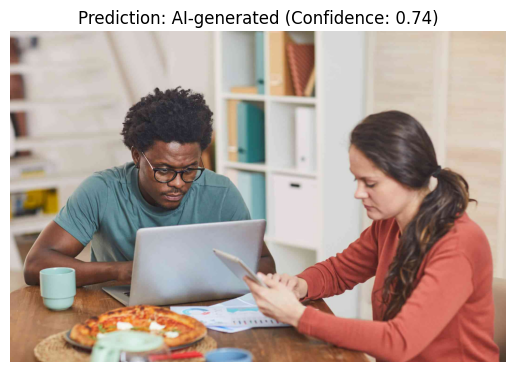

Prediction: AI-generated (Confidence: 0.74)


In [22]:
import tensorflow as tf
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt

# Load the saved model
model = tf.keras.models.load_model('idk.h5')

def preprocess_image(image):
    # Resize the image to 224x224
    resized_image = cv2.resize(image, (224, 224))
    # Convert BGR to RGB
    resized_image_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
    # Perform Error Level Analysis
    ela_image = error_level_analysis(resized_image_rgb)
    # Normalize the image
    normalized_image = ela_image / 255.0
    return normalized_image

def predict_image(image_path):
    # Read the image
    image = cv2.imread(image_path)
    # Preprocess the image
    processed_image = preprocess_image(image)
    # Add batch dimension
    input_image = np.expand_dims(processed_image, axis=0)
    # Make prediction
    prediction = model.predict(input_image)[0][0]
    # Determine the class and confidence
    if prediction > 0.5:
        class_name = "AI-generated"
        confidence = prediction
    else:
        class_name = "Real"
        confidence = 1 - prediction
    return f"{class_name} (Confidence: {confidence:.2f})"

# Example usage
image_path = '/kaggle/input/ai-generated-images-vs-real-images/RealArt/RealArt/-man-sits-with-a-woman-on-her-phone-at-a-table-while-looking-at-a-computer_l.jpg'  # Replace with the path to your test image
result = predict_image(image_path)

# Display the image and prediction
img = Image.open(image_path)
plt.imshow(img)
plt.axis('off')
plt.title(f"Prediction: {result}")
plt.show()

print(f"Prediction: {result}")